# **<h3 align="center">Machine Learning - Project</h3>**
## **<h3 align="center">3. Feature Engineering & Encoding</h3>**
### **<h3 align="center">Group 30 - Project</h3>**


### Group Members
| Name              | Email                        | Student ID |
|-------------------|------------------------------|------------|
| Alexandra Pinto   | 20211599@novaims.unl.pt      | 20211599   |
| Gonçalo Peres     | 20211625@novaims.unl.pt      | 20211625   |
| Leonor Mira       | 20240658@novaims.unl.pt      | 20240658   |
| Miguel Natário    | 20240498@novaims.unl.pt      | 20240498   |
| Nuno Bernardino   | 20211546@novaims.unl.pt      | 20211546   |

---

### **3. Feature Engineering & Encoding Notebook**
**Description:**  
This notebook builds upon the preprocessed dataset from the Preprocessing & Cleaning notebook to prepare features for hierarchical classification. Key steps include:  
- **Feature Engineering:** Create or transform features to enhance predictive power, including interaction terms, date-based calculations, and aggregations.  
- **Encoding Categorical Variables:** Apply encoding techniques suited to the cardinality and nature of categorical variables, such as ordinal encoding, one-hot encoding, or frequency encoding.  
- **Output:** Save the feature-engineered datasets (in CSV) for modeling in subsequent notebooks.  

This notebook ensures the dataset is optimally prepared for hierarchical classification, balancing feature relevance and computational efficiency.  

---

<a id = "toc"></a>

## Table of Contents
* [1. Import the Libraries](#chapter1)
* [2. Import the Datasets](#chapter2)       
* [3. Feature Engineering](#chapter3)
    * [3.1. Carrier-District Interaction](#section_3_1)
    * [3.2. Income Category](#section_3_2)
    * [3.3. Days_To_First_Hearing](#section_3_3)
    * [3.4. Accident Quarter](#section_3_4)
    * [3.5. Accident Year](#section_3_5)
    * [3.6. Accident on Day and Weekend](#section_3_6)
    * [3.7. Age Group](#section_3_7)
    * [3.8. Time from Assembly Date to C-2 Filing](#section_3_8)
    * [3.9. Time from Accident to C-2 Filing](#section_3_9)
    * [3.10. Zip_Code_Simplified](#section_3_10)
    * [3.11. Carrier Type Merged](#section_3_11)
    * [3.12. Carrier_Name_Simplified](#section_3_12)
    * [3.13. Body_Part_Category](#section_3_13)
    * [3.14. Injury_Nature_Category](#section_3_14)
    * [3.15. Injury_Cause_Category](#section_3_15)
    * [3.16. Risk of Each Job](#section_3_16)
    * [3.17. Relation between Salary and Dependents](#section_3_17)
* [4. Encoding and Feature Categorization](#chapter4)
    * [4.1. Encoding Features](#section_4_1)
    * [4.2. Feature Categorization](#section_4_2)
    * [4.3. Correlation Matrix for Numerical and Binary Features](#section_4_3)
* [5. Save Dataset for Modelling](#chapter5)



# 1. Import the Libraries 📚<a class="anchor" id="chapter1"></a>

[Back to ToC](#toc)<br>

In this section we will imported the needed libraries for this notebook.

In [1]:
# --- Standard Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile
import re
import os


# --- Scikit-Learn Modules for Data Partitioning and Preprocessing ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# --- Warnings ---
import warnings
warnings.filterwarnings('ignore')

#Import functions from utils
# from utils import analyze_numerical_outliers

# 2. Load and Prepare Datasets 📁<a class="anchor" id="chapter2"></a>
[Back to ToC](#toc)<br>

Now, we will load the dataset prepared in **Notebook 2: Preprocessing & Cleaning**, where we addressed key inconsistencies such as missing values and outliers. This preprocessed dataset serves as the foundation for the feature engineering steps in this notebook.

In [2]:
# Load the datasets saved from Notebook 2
X_train = pd.read_csv("../processed_datasets/X_train_preprocessed.csv", index_col="Claim Identifier")
X_val = pd.read_csv("../processed_datasets/X_val_preprocessed.csv", index_col="Claim Identifier")
df_test = pd.read_csv("../processed_datasets/df_test_preprocessed.csv", index_col="Claim Identifier")

# Verify the datasets are loaded successfully
X_train.head(), X_val.head(), df_test.head()

(                  Unnamed: 0 Accident Date  Age at Injury  \
 Claim Identifier                                            
 6099734                    0    2022-09-22             67   
 5796182                    1    2021-08-21             30   
 6128237                    2    2022-11-03             58   
 5394501                    3    2019-07-27             55   
 5452763                    4    2020-03-11             25   
 
                                   Assembly Date  Attorney/Representative  \
 Claim Identifier                                                           
 6099734           2022-10-03 00:00:00.000000000                      1.0   
 5796182           2021-08-24 00:00:00.000000000                      0.0   
 6128237           2022-11-08 00:00:00.000000000                      0.0   
 5394501           2020-01-03 00:00:00.000000000                      0.0   
 5452763           2020-03-13 00:00:00.000000000                      0.0   
 
                   Aver

In [3]:
X_train = X_train.drop(columns=['Unnamed: 0', 'Accident Year'])
#do the same for test and val
X_val = X_val.drop(columns=['Unnamed: 0', 'Accident Year'])
df_test = df_test.drop(columns=['Unnamed: 0', 'Accident Year'])

In [4]:
X_train.isna().sum()

Accident Date                 0
Age at Injury                 0
Assembly Date                 0
Attorney/Representative       0
Average Weekly Wage           0
Birth Year                    0
C-2 Date                      0
C-3 Date                      0
Carrier Name                  0
Carrier Type                  0
County of Injury              0
COVID-19 Indicator            0
District Name                 0
First Hearing Date            0
Gender                        0
IME-4 Count                   0
Industry Code                 0
Medical Fee Region            0
WCIO Cause of Injury Code     0
WCIO Nature of Injury Code    0
WCIO Part Of Body Code        0
Zip Code                      0
Agreement Reached             0
Number of Dependents          0
dtype: int64

# 3. Feature Engineering <a class="anchor" id="chapter3"></a>
[Back to ToC](#toc)<br>


Feature engineering is the process of preparing data for machine learning models by transforming raw data into meaningful features that enhance model performance. In this section, we create, select, and modify variables to capture significant patterns within the data, making it more informative and useful for the model’s learning process. Through these transformations, we aim to improve the model’s accuracy and effectiveness.

## 3.1. Carrier-District Interaction <a class="anchor" id="section_3_1"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>

Combining **Carrier Type** with **District Name** may reveal regional preferences for certain insurance carriers, which could be useful in understanding regional biases or regulations.

In [5]:
# Creating a new feature by combining Carrier Type and District Name
X_train['Carrier_District_Interaction'] = X_train['Carrier Type'] + "_" + X_train['District Name']

# Apply to the val X_val
X_val['Carrier_District_Interaction'] = X_val['Carrier Type'] + "_" + X_val['District Name']

# Apply to the test set
df_test['Carrier_District_Interaction'] = df_test['Carrier Type'] + "_" + df_test['District Name']

## 3.2. Income Category  <a class="anchor" id="section_3_2"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>

Creating categories for **Average Weekly Wage** can simplify the continuous nature of income into meaningful segments such as Low, Average, and High, which could help the model understand different socioeconomic statuses.

In [6]:
# Calculate key percentiles
percentiles = X_train['Average Weekly Wage'].quantile([0.25, 0.5, 0.75, 0.9])
print(percentiles)

0.25     876.0
0.50    1125.0
0.75    1269.0
0.90    1666.0
Name: Average Weekly Wage, dtype: float64


In [7]:
# Defining the bins and labels for categorizing income based on percentiles
income_bins = [0, 876.0, 1125.0, 1269.0, 1666.0, float('inf')]  # float('inf') allows us to set an open-ended range
income_labels = ['Low Income', 'Lower-Middle Income', 'Middle Income', 'Upper-Middle Income', 'High Income']

# Creating the new feature for income categories for the train set
X_train['Income_Category'] = pd.cut(X_train['Average Weekly Wage'], bins=income_bins, labels=income_labels)

# Apply to the val set
X_val['Income_Category'] = pd.cut(X_val['Average Weekly Wage'], bins=income_bins, labels=income_labels)

# Apply to the test set
df_test['Income_Category'] = pd.cut(df_test['Average Weekly Wage'], bins=income_bins, labels=income_labels)

In [8]:
X_train['Income_Category'].value_counts()

Income_Category
Middle Income          118412
Lower-Middle Income    115847
Low Income             114892
Upper-Middle Income     67688
High Income             42380
Name: count, dtype: int64

## 3.3. Days_To_First_Hearing  <a class="anchor" id="section_3_3"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>


The feature **Days_To_First_Hearing** was created to capture the number of days between the Accident Date and the First Hearing Date. If a First Hearing Date is available, the feature represents the time elapsed, which can help the model understand the speed of the claim process. If the First Hearing Date is missing, it is represented as 0, indicating that a hearing has not occurred yet. This approach provides more nuanced information than simply indicating whether the hearing occurred or not, allowing the model to learn from both the presence and timing of the first hearing.

In [9]:
# List of columns to convert to datetime
date_columns = ['First Hearing Date', 'C-2 Date', 'C-3 Date']

# Replace 0 with NaT and convert to datetime
for col in date_columns:
    if col in X_train.columns:  # Check if the column exists in the DataFrame
        X_train[col] = pd.to_datetime(X_train[col].replace(0, pd.NaT), errors='coerce')
    if col in X_val.columns:
        X_val[col] = pd.to_datetime(X_val[col].replace(0, pd.NaT), errors='coerce')
    if col in df_test.columns:
        df_test[col] = pd.to_datetime(df_test[col].replace(0, pd.NaT), errors='coerce')

# Verify the conversion
print("First Hearing Date column after conversion:")
print(X_train['First Hearing Date'].head())
print("C-2 Date column after conversion:")
print(X_train['C-2 Date'].head())
print("C-3 Date column after conversion:")
print(X_train['C-3 Date'].head())

First Hearing Date column after conversion:
Claim Identifier
6099734   2023-02-28
5796182          NaT
6128237          NaT
5394501   2020-03-20
5452763          NaT
Name: First Hearing Date, dtype: datetime64[ns]
C-2 Date column after conversion:
Claim Identifier
6099734   2022-10-01
5796182   2021-08-24
6128237   2022-11-08
5394501   2020-01-15
5452763   2020-03-13
Name: C-2 Date, dtype: datetime64[ns]
C-3 Date column after conversion:
Claim Identifier
6099734   2022-10-28
5796182          NaT
6128237          NaT
5394501   2019-12-20
5452763          NaT
Name: C-3 Date, dtype: datetime64[ns]


In [10]:
# Convert date columns to datetime
date_columns = ['First Hearing Date', 'Accident Date']
for col in date_columns:
    X_train[col] = pd.to_datetime(X_train[col], errors='coerce')
    X_val[col] = pd.to_datetime(X_val[col], errors='coerce')
    df_test[col] = pd.to_datetime(df_test[col], errors='coerce')

# Function to calculate days to first hearing
def calculate_hearing_days(row):
    if pd.notna(row['First Hearing Date']) and pd.notna(row['Accident Date']):
        return (row['First Hearing Date'] - row['Accident Date']).days
    return 0  # If no hearing date exists, return 0

# Apply the function to create the new feature
X_train['Days_To_First_Hearing'] = X_train.apply(calculate_hearing_days, axis=1)
X_val['Days_To_First_Hearing'] = X_val.apply(calculate_hearing_days, axis=1)
df_test['Days_To_First_Hearing'] = df_test.apply(calculate_hearing_days, axis=1)

# Verify the new feature
print("Days_To_First_Hearing in Train Set:")
print(X_train['Days_To_First_Hearing'].describe())

Days_To_First_Hearing in Train Set:
count    459219.000000
mean         88.993785
std         270.600201
min          -5.000000
25%           0.000000
50%           0.000000
75%          72.000000
max       16373.000000
Name: Days_To_First_Hearing, dtype: float64


After creating this binary feature, we can drop the original First Hearing Date column from the training, validation, and test sets, since most of the values are equal to 0.

In [11]:
# Drop First Hearing Date from the train, val, and test sets
X_train_processed = X_train.drop(columns=['First Hearing Date'])
X_val_processed = X_val.drop(columns=['First Hearing Date'])
df_test_processed = df_test.drop(columns=['First Hearing Date'])

## 3.4. Accident Quarter  <a class="anchor" id="section_3_4"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>


Temporal data can often influence outcomes. Extracting the quarter of the accident (e.g., 1st, 2nd, etc.) helps the model capture seasonal patterns that may impact accidents.

In [12]:
# Extracting the quarter of the Accident Date
X_train_processed['Accident_Quarter'] = pd.to_datetime(X_train_processed['Accident Date'], errors='coerce').dt.quarter

# Apply to the val set
X_val_processed['Accident_Quarter'] = pd.to_datetime(X_val_processed['Accident Date'], errors='coerce').dt.quarter

# Apply to the test set
df_test_processed['Accident_Quarter'] = pd.to_datetime(df_test_processed['Accident Date'], errors='coerce').dt.quarter


## 3.5. Accident Year <a class="anchor" id="section_3_5"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>


The year can help the model understand seasonal or yearly effects, like accident patterns during different times of the year.

In [13]:
# Extracting the year from the Accident Date
X_train_processed['Accident_Year'] = pd.to_datetime(X_train_processed['Accident Date'], errors='coerce').dt.year

# Apply to the val set
X_val_processed['Accident_Year'] = pd.to_datetime(X_val_processed['Accident Date'], errors='coerce').dt.year

# Apply to the test set
df_test_processed['Accident_Year'] = pd.to_datetime(df_test_processed['Accident Date'], errors='coerce').dt.year

## 3.6. Accident on Day and Weekend <a class="anchor" id="section_3_6"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>


The day of the accident could be significant, as weekends might have different risk factors compared to weekdays. We will extract the day of the week and create a feature to indicate if the accident occurred on a weekend.

In [14]:
# Extracting the day of the week and creating a feature to indicate if the accident occurred on a weekend
X_train_processed['Accident Day'] = pd.to_datetime(X_train_processed['Accident Date'], errors='coerce').dt.dayofweek
X_train_processed['Accident on Weekend'] = X_train_processed['Accident Day'].apply(lambda x: 1 if x >= 5 else 0)

# Apply to the val set
X_val_processed['Accident Day'] = pd.to_datetime(X_val_processed['Accident Date'], errors='coerce').dt.dayofweek
X_val_processed['Accident on Weekend'] = X_val_processed['Accident Day'].apply(lambda x: 1 if x >= 5 else 0)

# Apply to the test set
df_test_processed['Accident Day'] = pd.to_datetime(df_test_processed['Accident Date'], errors='coerce').dt.dayofweek
df_test_processed['Accident on Weekend'] = df_test_processed['Accident Day'].apply(lambda x: 1 if x >= 5 else 0)

## 3.7. Age Group <a class="anchor" id="section_3_7"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>

Grouping ages can help simplify the model’s understanding of different age demographics (e.g., Youth, Young Adult, Middle Age, Senior). This could potentially improve model interpretability and performance.

In [15]:
# Display unique values in 'Age at Injury' to understand the range
X_train_processed['Age at Injury'].describe()

count    459219.000000
mean         42.884970
std          12.952508
min           5.000000
25%          33.000000
50%          42.000000
75%          53.000000
max          82.000000
Name: Age at Injury, dtype: float64

In [16]:
# Creating bins and labels for age groups
age_bins = [0, 25, 45, 65, float('inf')]
age_labels = ['Youth', 'Young Adult', 'Middle Age', 'Senior']

# Creating a new feature for age groups
X_train_processed['Age Group'] = pd.cut(X_train_processed['Age at Injury'], bins=age_bins, labels=age_labels)

# Apply to the val set
X_val_processed['Age Group'] = pd.cut(X_val_processed['Age at Injury'], bins=age_bins, labels=age_labels)

# Apply to the test set
df_test_processed['Age Group'] = pd.cut(df_test_processed['Age at Injury'], bins=age_bins, labels=age_labels)

## 3.8. Promptness_category <a class="anchor" id="section_3_8"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>


The `promptness_category` feature categorizes the time taken between key events in the claims process, specifically measuring the difference between the `Accident Date` and the `Assembly Date`. This feature quantifies the speed or delay in assembling the claim and provides insight into how promptly claims are processed.

In [17]:
import pandas as pd

def categorize_promptness(df, date1_col, date2_col, new_col_name):
    """
    Calculate and categorize promptness between two date columns.

    Parameters:
    - df: The DataFrame to process.
    - date1_col: The column representing the first date (e.g., Assembly Date).
    - date2_col: The column representing the second date (e.g., Accident Date).
    - new_col_name: The name of the new categorical column for promptness.

    Returns:
    - Updated DataFrame with new categorized promptness column.
    """
    # Ensure the date columns are datetime
    df[date1_col] = pd.to_datetime(df[date1_col], errors='coerce')
    df[date2_col] = pd.to_datetime(df[date2_col], errors='coerce')

    # Calculate the difference in days
    df['Days_Difference'] = (df[date1_col] - df[date2_col]).dt.days

    # Assign categories based on conditions
    def assign_category(row):
        if pd.isna(row[date1_col]) or pd.isna(row[date2_col]) or row['Days_Difference'] <= 0:
            return 'Form Not Received'
        elif row['Days_Difference'] <= 7:
            return 'Until 1 week'
        elif row['Days_Difference'] <= 14:
            return 'Between 1 and 2 weeks'
        elif row['Days_Difference'] <= 30:
            return 'Between 2 weeks and 1 month'
        elif row['Days_Difference'] <= 90:
            return '1 to 3 months'
        elif row['Days_Difference'] <= 180:
            return '3 to 6 months'
        elif row['Days_Difference'] <= 365:
            return '6 months to 1 year'
        else:
            return 'More than 1 year'

    # Apply the function to assign categories
    df[new_col_name] = df.apply(assign_category, axis=1)

    # Drop the intermediate column
    df.drop(columns=['Days_Difference'], inplace=True)

    return df

# Apply the function to X_train_processed
X_train_processed = categorize_promptness(X_train_processed, 'Assembly Date', 'Accident Date', 'promptness_category')

# Apply the function to X_val_processed
X_val_processed = categorize_promptness(X_val_processed, 'Assembly Date', 'Accident Date', 'promptness_category')

# Apply the function to df_test_processed
df_test_processed = categorize_promptness(df_test_processed, 'Assembly Date', 'Accident Date', 'promptness_category')

In [18]:
# Display value counts for the new column
X_train_processed['promptness_category'].value_counts()

promptness_category
Until 1 week                   182309
Between 1 and 2 weeks           97525
Between 2 weeks and 1 month     77102
1 to 3 months                   58174
3 to 6 months                   17709
More than 1 year                12507
6 months to 1 year              10845
Form Not Received                3048
Name: count, dtype: int64

These categories allow us to observe the promptness in claim processing, with the majority falling within Until 1 week, indicating a generally swift assembly of claims. However, a significant portion extends beyond a month, with a small subset taking more than a year. This feature can provide insights into patterns of delays or rapid processing, possibly indicating areas for improvement in claim management.

## 3.9. promptness_C2_category <a class="anchor" id="section_3_9"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>

The "promptness_C2_category" feature tracks the time taken to register the C-2 Date (the receipt of the employer's report of work-related injury/illness) after the Accident Date. It evaluates employers' promptness in reporting accidents, offering insights into compliance and potential administrative delays.


In [19]:
# Ensure 'C-2 Date' and 'Accident Date' are datetime
X_train_processed['C-2 Date'] = pd.to_datetime(X_train_processed['C-2 Date'], errors='coerce')
X_train_processed['Accident Date'] = pd.to_datetime(X_train_processed['Accident Date'], errors='coerce')

# Count the number of rows where 'C-2 Date' is earlier than 'Accident Date'
num_negative_values = (X_train_processed['C-2 Date'] < X_train_processed['Accident Date']).sum()

# Print the number of rows with this condition
print(f"Number of rows where 'C-2 Date' is earlier than 'Accident Date': {num_negative_values}")

Number of rows where 'C-2 Date' is earlier than 'Accident Date': 69


In these cases, where the C-2 Date is earlier than the Accident Date, we identify them as incorrect or inconsistent entries. This issue may have been introduced during the imputation of missing values. To resolve this, we will set the affected C-2 Date values to NaT (Not a Time), ensuring the data remains clean and consistent.

In [20]:
# Identify rows where 'C-2 Date' is earlier than 'Accident Date'
invalid_c2_date_mask = X_train_processed['C-2 Date'] < X_train_processed['Accident Date']

# Set 'C-2 Date' to NaT for the identified rows
X_train_processed.loc[invalid_c2_date_mask, 'C-2 Date'] = pd.NaT

# Verify the changes
num_invalid_c2_dates = invalid_c2_date_mask.sum()
print(f"Number of 'C-2 Date' values set to NaT: {num_invalid_c2_dates}")

Number of 'C-2 Date' values set to NaT: 69


Apply the code.

In [21]:
# Apply the function to X_train_processed
X_train_processed = categorize_promptness(X_train_processed, 'C-2 Date', 'Accident Date', 'promptness_C2_category')

# Apply the function to X_val_processed
X_val_processed = categorize_promptness(X_val_processed, 'C-2 Date', 'Accident Date', 'promptness_C2_category')

# Apply the function to df_test_processed
df_test_processed = categorize_promptness(df_test_processed, 'C-2 Date', 'Accident Date', 'promptness_C2_category')


In [22]:
# Display value counts for the new column
X_train_processed['promptness_C2_category'].value_counts()

promptness_C2_category
Until 1 week                   183304
Between 1 and 2 weeks           86992
Between 2 weeks and 1 month     68979
1 to 3 months                   56602
3 to 6 months                   21417
Form Not Received               15631
6 months to 1 year              14305
More than 1 year                11989
Name: count, dtype: int64

## 3.10. promptness_C3_category <a class="anchor" id="section_3_10"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>

The "promptness_C3_category" feature tracks the time taken to register the C-3 Date (the receipt of the employer's report of work-related injury/illness) after the Accident Date. It evaluates employers' promptness in reporting accidents, offering insights into compliance and potential administrative delays.


In [23]:
# Apply the function to X_train_processed
X_train_processed = categorize_promptness(X_train_processed, 'C-3 Date', 'Accident Date', 'promptness_C3_category')

# Apply the function to X_val_processed
X_val_processed = categorize_promptness(X_val_processed, 'C-3 Date', 'Accident Date', 'promptness_C3_category')

# Apply the function to df_test_processed
df_test_processed = categorize_promptness(df_test_processed, 'C-3 Date', 'Accident Date', 'promptness_C3_category')

In [24]:
# Display value counts for the new column
X_train_processed['promptness_C3_category'].value_counts()

promptness_C3_category
Form Not Received              311530
1 to 3 months                   36320
Between 2 weeks and 1 month     35159
Between 1 and 2 weeks           22154
Until 1 week                    21016
3 to 6 months                   14384
6 months to 1 year              10074
More than 1 year                 8582
Name: count, dtype: int64

After creating new features based on the existing date columns, we will remove the original date features to avoid redundancy and simplify the dataset. We believe that the impact of these date features is adequately captured in the newly engineered features.

In [25]:
X_train_processed = X_train_processed.drop(columns=['Accident Date', 'Assembly Date', 'C-2 Date','C-3 Date'])

#Apply to the val set
X_val_processed = X_val_processed.drop(columns=['Accident Date','Assembly Date', 'C-2 Date','C-3 Date'])

# Apply to the test set
df_test_processed = df_test_processed.drop(columns=['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date'])

## 3.10. Zip_Code_Simplified <a class="anchor" id="section_3_10"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>

To reduce the dimensionality of the Zip Code feature, we will create a new feature called Zip_Code_Simplified. This feature will group all zip codes that appear less than 2,000 times in the training dataset into a category labeled as 'Other'. By doing this, we effectively reduce the number of unique zip codes, simplifying the model while retaining the most significant information.

In [26]:
# Print the most frequent Carrier Names along with their counts
most_frequent_zipcode = X_train_processed['Zip Code'].value_counts().head(25)  # Adjust the number if you need more
print("Most frequent Zip Codes with their counts:")
print(most_frequent_zipcode)

Most frequent Zip Codes with their counts:
Zip Code
11236.0    4144
11706.0    4090
11434.0    3887
11550.0    3133
10467.0    2969
10940.0    2635
10701.0    2320
10029.0    2211
14224.0    2125
10314.0    1978
11717.0    1962
11207.0    1854
14609.0    1853
11368.0    1837
11208.0    1815
12550.0    1780
11212.0    1757
11226.0    1735
12601.0    1719
11234.0    1612
10466.0    1598
11203.0    1583
10462.0    1522
10456.0    1515
11385.0    1502
Name: count, dtype: int64


In [27]:
# Create a new feature called 'Zip_Code_Simplified' based on 'Zip Code' for train, validation, and test sets
X_train_processed['Zip_Code_Simplified'] = X_train_processed['Zip Code']
X_val_processed['Zip_Code_Simplified'] = X_val_processed['Zip Code']
df_test_processed['Zip_Code_Simplified'] = df_test_processed['Zip Code']

# Identify carrier names that occur fewer than 1000 times in X_train_processed
zipcode_counts = X_train_processed['Zip Code'].value_counts()
zipcode_to_replace = zipcode_counts[zipcode_counts < 1000].index

# Replace carrier names with fewer than 1000 occurrences with 'OTHER' in all datasets using the identified carriers from X_train
for dataset in [X_train_processed, X_val_processed, df_test_processed]:
    dataset['Zip_Code_Simplified'] = dataset['Zip_Code_Simplified'].replace(zipcode_to_replace, 'OTHER')

# Print the counts of the simplified carrier names in X_train_processed to verify the result
print("Counts of 'Zip_Code_Simplified' feature in X_train_processed:")
print(X_train_processed['Zip_Code_Simplified'].value_counts())

Counts of 'Zip_Code_Simplified' feature in X_train_processed:
Zip_Code_Simplified
OTHER      350333
11236.0      4144
11706.0      4090
11434.0      3887
11550.0      3133
            ...  
14150.0      1011
13760.0      1009
11691.0      1005
10306.0      1004
10460.0      1002
Name: count, Length: 71, dtype: int64


In [28]:
# Display unique counts to compare the dimensionality reduction
print(f"Original ZIP Code uniqueness: {X_train_processed['Zip Code'].nunique()}")
print(f"Simplified ZIP Code uniqueness: {X_train_processed['Zip_Code_Simplified'].nunique()}")

Original ZIP Code uniqueness: 11443
Simplified ZIP Code uniqueness: 71


## 3.11. Carrier Type Merged <a class="anchor" id="section_3_11"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>


Since there are several categories under "Special Fund" with very few occurrences, combining them into a single category can reduce noise in the data and make the feature more manageable for the model.

After merging, we observe the following distribution of Carrier Type Merged values in the training dataset:

In [29]:
# Creating a new feature that merges all 'Special Fund' categories into a single category for train, validation, and test sets
for dataset in [X_train_processed, X_val_processed, df_test_processed]:
    dataset['Carrier Type Merged'] = dataset['Carrier Type'].replace({
        'SPECIAL FUND - UNKNOWN': 'SPECIAL FUND',
        'SPECIAL FUND - POI CARRIER WCB MENANDS': 'SPECIAL FUND',
        'SPECIAL FUND - CONS. COMM. (SECT. 25-A)': 'SPECIAL FUND'
    })

# Verifying the updated column for X_train_processed
print(X_train_processed['Carrier Type Merged'].value_counts())

Carrier Type Merged
PRIVATE         228492
SELF PUBLIC      97456
SIF              88862
SELF PRIVATE     42169
UNKNOWN           1407
SPECIAL FUND       833
Name: count, dtype: int64


In [30]:
X_train_processed['Carrier Type'].value_counts()

Carrier Type
PRIVATE                                    228492
SELF PUBLIC                                 97456
SIF                                         88862
SELF PRIVATE                                42169
UNKNOWN                                      1407
SPECIAL FUND - UNKNOWN                        828
SPECIAL FUND - CONS. COMM. (SECT. 25-A)         3
SPECIAL FUND - POI CARRIER WCB MENANDS          2
Name: count, dtype: int64

## 3.12. Carrier_Name_Simplified <a class="anchor" id="section_3_12"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>

The 'Carrier Name' feature has high cardinality, with 1951 unique values. This level of uniqueness can complicate machine learning models, especially if some categories have very few instances. To simplify the analysis and potentially improve model performance, we will group carrier names with fewer than 500 occurrences under a single category called 'OTHER'.


In [31]:
# Print the most frequent Carrier Names along with their counts
most_frequent_carriers = X_train_processed['Carrier Name'].value_counts().head(25)  # Adjust the number if you need more
print("Most frequent Carrier Names with their counts:")
print(most_frequent_carriers)

Most frequent Carrier Names with their counts:
Carrier Name
STATE INSURANCE FUND             88862
POLICE, FIRE, SANITATION         17247
AMERICAN ZURICH INSURANCE CO     14012
CHARTER OAK FIRE INS CO          13697
INDEMNITY INS. OF N AMERICA      11544
SAFETY NATIONAL CASUALTY CORP    11163
NEW HAMPSHIRE INSURANCE CO       10237
LM INSURANCE CORP                 9830
A I U INSURANCE COMPANY           8907
INDEMNITY INSURANCE CO OF         7246
NYC TRANSIT AUTHORITY             6603
HARTFORD ACCIDENT & INDEMNITY     6039
NEW YORK BLACK CAR OPERATORS'     5841
ARCH INDEMNITY INSURANCE CO.      5321
AIU INSURANCE CO                  5181
CNY OTHER THAN ED, HED WATER      5161
HEALTH & HOSPITAL CORP.           4478
ARCH INDEMNITY INSURANCE CO       4281
PENNSYLVANIA MANUFACTURERS'       3899
PUBLIC EMPLOYERS RISK MGMT.       3656
ACE AMERICAN INSURANCE CO.        3623
OLD REPUBLIC INSURANCE CO.        3487
MEMIC INDEMNITY COMPANY           3295
WAL-MART ASSOCIATES, INC.         3158
COUN

In [32]:
# Create a new feature called 'Carrier_Name_Simplified' based on 'Carrier Name' for train, validation, and test sets
X_train_processed['Carrier_Name_Simplified'] = X_train_processed['Carrier Name']
X_val_processed['Carrier_Name_Simplified'] = X_val_processed['Carrier Name']
df_test_processed['Carrier_Name_Simplified'] = df_test_processed['Carrier Name']

# Identify carrier names that occur fewer than 500 times in X_train_processed
carrier_counts = X_train_processed['Carrier Name'].value_counts()
carriers_to_replace = carrier_counts[carrier_counts < 500].index

# Replace carrier names with fewer than 500 occurrences with 'OTHER' in all datasets using the identified carriers from X_train
for dataset in [X_train_processed, X_val_processed, df_test_processed]:
    dataset['Carrier_Name_Simplified'] = dataset['Carrier_Name_Simplified'].replace(carriers_to_replace, 'OTHER')

# Print the counts of the simplified carrier names in X_train_processed to verify the result
print("Counts of 'Carrier_Name_Simplified' feature in X_train_processed:")
print(X_train_processed['Carrier_Name_Simplified'].value_counts())

Counts of 'Carrier_Name_Simplified' feature in X_train_processed:
Carrier_Name_Simplified
OTHER                            93013
STATE INSURANCE FUND             88862
POLICE, FIRE, SANITATION         17247
AMERICAN ZURICH INSURANCE CO     14012
CHARTER OAK FIRE INS CO          13697
                                 ...  
TOWN OF OYSTER BAY                 519
NY LUMBERMENS INS. TRUST FUND      515
AMTRUST INS CO OF KANSAS INC       512
YONKERS, CITY OF                   510
HEALTH & HOSPITALS CORP. CNY       505
Name: count, Length: 115, dtype: int64


In [33]:
#print the number of unique values in the original 'Carrier Name' feature
print(f"Number of unique values in 'Carrier Name': {X_train_processed['Carrier Name'].nunique()}")

#print the number of unique values in the simplified 'Carrier_Name_Simplified' feature
print(f"Number of unique values in 'Carrier_Name_Simplified': {X_train_processed['Carrier_Name_Simplified'].nunique()}")

Number of unique values in 'Carrier Name': 1996
Number of unique values in 'Carrier_Name_Simplified': 115


In [34]:
#sum all nan values from train, val, test
X_train_processed.isnull().sum().sum(), X_val_processed.isnull().sum().sum(), df_test_processed.isnull().sum().sum()

(0, 0, 0)

## 3.13. Body_Part_Category <a class="anchor" id="section_3_13"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>

The Body_Part_Category feature will group the WCIO_Part_of_Body_Code into broader categories. Based on the codes in your document, each range of codes represents a specific body part region (e.g., codes from 10 to 19 represent the head). We’ll map these codes to corresponding regions like “Head,” “Neck,” etc.

In [35]:
# Mapping of WCIO Part of Body codes to broader categories
part_of_body_mapping = {
    **dict.fromkeys(range(10, 20), 'Head'),
    **dict.fromkeys(range(20, 30), 'Neck'),
    **dict.fromkeys(range(30, 40), 'Upper Extremities'),
    **dict.fromkeys(list(range(40, 50)) + list(range(60, 64)), 'Trunk'),
    **dict.fromkeys(range(50, 60), 'Lower Extremities'),
    **dict.fromkeys([64, 65, 66, 90, 91, 99], 'Multiple Body Parts'),
    **dict.fromkeys([101], 'NonClassificable'),
    0: 'No_Code'  # Explicitly add 'No_Code' for values of 0
}

# Apply mapping to the training set
X_train_processed['Body_Part_Category'] = X_train_processed['WCIO Part Of Body Code'].map(part_of_body_mapping)

# Apply mapping to the validation set
X_val_processed['Body_Part_Category'] = X_val_processed['WCIO Part Of Body Code'].map(part_of_body_mapping)

# Apply mapping to the test set
df_test_processed['Body_Part_Category'] = df_test_processed['WCIO Part Of Body Code'].map(part_of_body_mapping)

In [36]:
X_train_processed['Body_Part_Category'].value_counts()

Body_Part_Category
Upper Extremities      142559
Lower Extremities       96343
Trunk                   80866
Head                    45491
Multiple Body Parts     37241
NonClassificable        33562
No_Code                 13564
Neck                     9593
Name: count, dtype: int64

In [37]:
X_train_processed['Body_Part_Category'].isna().sum()

0

## 3.14. Injury_Nature_Category <a class="anchor" id="section_3_14"></a>
The Body_Part_Category feature will group the WCIO_Part_of_Body_Code into broader categories. Based on the codes in the document, each range of codes represents a specific body part region (e.g., codes from 10 to 19 represent the head). We will map these codes to corresponding regions like "Head," "Neck," etc.

In [38]:
# Mapping of WCIO Nature of Injury codes to broader categories
nature_of_injury_mapping = {
    **dict.fromkeys(range(1, 60), 'Specific Injury'),
    **dict.fromkeys(range(60, 81), 'Occupational Disease or Cumulative Injury'),
    **dict.fromkeys([83], 'COVID-19 Injury'),
    **dict.fromkeys([90, 91], 'Multiple Injuries'),
    0: 'No_Code'  # Explicitly add 'No_Code' for values of 0
}

# Creating the Injury_Nature_Category column by mapping Nature of Injury codes to categories
X_train_processed['Injury_Nature_Category'] = X_train_processed['WCIO Nature of Injury Code'].map(nature_of_injury_mapping)

#Apply to the val set
X_val_processed['Injury_Nature_Category'] = X_val_processed['WCIO Nature of Injury Code'].map(nature_of_injury_mapping)

# Apply to the test set
df_test_processed['Injury_Nature_Category'] = df_test_processed['WCIO Nature of Injury Code'].map(nature_of_injury_mapping)


In [39]:
X_train_processed['Injury_Nature_Category'].value_counts()

Injury_Nature_Category
Specific Injury                              404174
COVID-19 Injury                               20663
No_Code                                       12463
Occupational Disease or Cumulative Injury     11439
Multiple Injuries                             10480
Name: count, dtype: int64

In [40]:
X_train_processed['Injury_Nature_Category'].isna().sum()

0

## 3.15. Injury_Cause_Category <a class="anchor" id="section_3_15"></a>
The Injury_Cause_Category feature will classify the WCIO_Cause_of_Injury_Code values into broader cause categories. For example, codes related to burns or scalds can be grouped together, as well as those for falls or motor vehicle accidents.

In [41]:
# Mapping of WCIO Cause of Injury codes to broader categories
cause_of_injury_mapping = {
    **dict.fromkeys(list(range(1, 10)) + [11, 14, 84], 'Burn or Scald'),
    **dict.fromkeys([10, 12, 13, 20], 'Caught In, Under, or Between'),
    **dict.fromkeys(list(range(15, 20)), 'Cut, Puncture, Scrape'),
    **dict.fromkeys(list(range(25, 34)), 'Fall, Slip, or Trip'),
    **dict.fromkeys(list(range(40, 51)), 'Motor Vehicle'),
    **dict.fromkeys(list(range(52, 62)) + [97], 'Strain or Injury By'),
    **dict.fromkeys(list(range(65, 71)), 'Striking Against or Stepping On'),
    **dict.fromkeys(list(range(74, 82)) + [85, 86], 'Struck or Injured by'),
    **dict.fromkeys(list(range(94, 96)), 'Rubbed or Abraded by'),
    **dict.fromkeys(list(range(87, 94)) + [96, 98, 99, 82], 'Miscellaneous Causes'),
    **dict.fromkeys([83], 'COVID-19 Injury'),
    0: 'No_Code'  # Explicitly add 'No_Code' for values of 0
}


# Creating the Injury_Cause_Category column by mapping Cause of Injury codes to categories
X_train_processed['Injury_Cause_Category'] = X_train_processed['WCIO Cause of Injury Code'].map(cause_of_injury_mapping)

# Apply to the val set
X_val_processed['Injury_Cause_Category'] = X_val_processed['WCIO Cause of Injury Code'].map(cause_of_injury_mapping)

# Apply to the test set
df_test_processed['Injury_Cause_Category'] = df_test_processed['WCIO Cause of Injury Code'].map(cause_of_injury_mapping)


In [42]:
X_train_processed['Injury_Cause_Category'].value_counts()

Injury_Cause_Category
Strain or Injury By                118515
Fall, Slip, or Trip                 95955
Struck or Injured by                80324
Miscellaneous Causes                38713
Cut, Puncture, Scrape               32369
COVID-19 Injury                     20098
Motor Vehicle                       19259
Striking Against or Stepping On     15526
Caught In, Under, or Between        15402
No_Code                             12448
Burn or Scald                        9833
Rubbed or Abraded by                  777
Name: count, dtype: int64

## 3.16. Risk of Each Job <a class="anchor" id="section_3_16"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>


In [43]:
high_risk = [11, 21, 23, 31, 32, 33, 48, 49]

medium_risk = [22, 42, 44, 45, 56, 62, 71, 72, 81, 92]

low_risk = [51, 52, 53, 54, 55, 61]

In [44]:
# Define a function to assign risk levels based on the industry code
def assign_risk(industry_code):
    if industry_code in high_risk:
        return 'High Risk'
    elif industry_code in medium_risk:
        return 'Medium Risk'
    elif industry_code in low_risk:
        return 'Low Risk'
    else:
        return 'Unknown Risk'

# Apply the function to create the 'Industry Risk' column for train and test datasets
X_train_processed['Industry Risk'] = X_train_processed['Industry Code'].apply(assign_risk)
X_val_processed['Industry Risk'] = X_val_processed['Industry Code'].apply(assign_risk)
df_test_processed['Industry Risk'] = df_test['Industry Code'].apply(assign_risk)

In [45]:
X_train_processed['Industry Risk'].value_counts()

Industry Risk
Medium Risk    293731
High Risk      101032
Low Risk        64456
Name: count, dtype: int64

## 3.17. Relation between Salary and Dependents <a class="anchor" id="section_3_17"></a>
[Back to 3. Feature Engineering ](#chapter3)<br>

The variable `Salary_Per_Dependent` denotes the average salary allocated per dependent in a household. This metric may provide valuable insights into the financial responsibilities faced by individuals and families, as well as their potential correlation with the frequency and severity of injury claims.

In [46]:
# Creating a new feature: dividing the salary (Average Weekly Wage) by the number of dependents
X_train_processed['Salary_Per_Dependent'] = X_train_processed['Average Weekly Wage'] / (X_train_processed['Number of Dependents'] + 1)

# Apply the same transformation to the validation set
X_val_processed['Salary_Per_Dependent'] = X_val_processed['Average Weekly Wage'] / (X_val_processed['Number of Dependents'] + 1)

# Apply the same transformation to the test set
df_test_processed['Salary_Per_Dependent'] = df_test_processed['Average Weekly Wage'] / (df_test_processed['Number of Dependents'] +1 )

In [47]:
X_train_processed['Salary_Per_Dependent'].describe()

count    459219.000000
mean        436.143125
std         405.110006
min           3.285714
25%         187.500000
50%         284.250000
75%         544.000000
max       10000.000000
Name: Salary_Per_Dependent, dtype: float64

# 4. Encoding and Feature Categorization <a class="anchor" id="chapter4"></a>
[Back to ToC](#toc)<br>


In this section, categorical features are encoded to make the dataset suitable for machine learning models. Encoding techniques are chosen based on the nature and cardinality of the categorical features, ensuring they retain their information while being represented numerically. This step prevents repetitive encoding in subsequent modeling notebooks, ensuring consistency and efficiency across the pipeline.

The final encoded dataset is saved and ready for immediate use in hierarchical modeling.

In [48]:
#To make sure that we keep the preprocessed dataset without the encoded columns
X_train_processed_copy = X_train_processed.copy()
X_val_processed_copy = X_val_processed.copy()
df_test_processed_copy = df_test_processed.copy()

## 4.1 Encoding Features <a class="anchor" id="section_4_1"></a>
[Back to 4. Encoding and Feature Categorization](#chapter4)<br>

To prepare the dataset for machine learning models, categorical features were encoded using different techniques based on their properties:

Ordinal Features: Features with inherent order, such as Age Group and Income_Category, were encoded using Label Encoding. <br>
Nominal Features with Low Cardinality: Features with a small number of unique categories, such as Gender and Medical Fee Region, were encoded using One-Hot Encoding. <br>
Nominal Features with High Cardinality: Features with a large number of unique categories, such as Zip Codes and Carrier Names, were encoded using Frequency Encoding.<br>

This approach ensures the dataset is transformed into a numerical format, maintaining information relevance while balancing computational efficiency.

In [49]:
# Columns to encode
ordinal_features = ['promptness_category', 'promptness_C2_category','promptness_C3_category', 'Age Group', 'Income_Category', 'Industry Risk']
low_cardinality_cols = ['Gender', 'Medical Fee Region']
high_cardinality_cols = ['Carrier_Name_Simplified', 'Zip_Code_Simplified', 'Industry Code', 'County of Injury', 
                         'Injury_Cause_Category','District Name','Carrier Type','WCIO Cause of Injury Code',
                         'WCIO Nature of Injury Code', 'WCIO Part Of Body Code','Carrier_District_Interaction','Carrier Name',
                         'Body_Part_Category','Injury_Nature_Category', 'Carrier Type Merged', 'Zip Code'
                         ]

In [50]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd

def encode_features(X_train, X_val, X_test, ordinal_features, low_cardinality_cols, high_cardinality_cols):
    """
    Encodes categorical features using Label Encoding, One-Hot Encoding, and Frequency Encoding.

    Parameters:
        - X_train: Training dataset (DataFrame).
        - X_val: Validation dataset (DataFrame).
        - X_test: Test dataset (DataFrame).
        - ordinal_features: List of ordinal feature columns for Label Encoding.
        - low_cardinality_cols: List of low-cardinality features for One-Hot Encoding.
        - high_cardinality_cols: List of high-cardinality features for Frequency Encoding.

    Returns:
        - X_train_final: Encoded training dataset.
        - X_val_final: Encoded validation dataset.
        - X_test_final: Encoded test dataset.
    """
    # Copy datasets to avoid modifying originals
    X_train_copy = X_train.copy()
    X_val_copy = X_val.copy()
    X_test_copy = X_test.copy()
    
    # Step 1: Label Encoding for ordinal features
    label_encoder = LabelEncoder()
    for col in ordinal_features:
        print(f"Label Encoding ordinal feature: {col}")
        X_train_copy[col] = label_encoder.fit_transform(X_train_copy[col])
        X_val_copy[col] = label_encoder.transform(X_val_copy[col])
        X_test_copy[col] = label_encoder.transform(X_test_copy[col])
    
    # Step 2: One-Hot Encoding for low-cardinality features
    print("\nOne-Hot Encoding low-cardinality features...")
    one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
    
    one_hot_train = one_hot_encoder.fit_transform(X_train_copy[low_cardinality_cols])
    one_hot_val = one_hot_encoder.transform(X_val_copy[low_cardinality_cols])
    one_hot_test = one_hot_encoder.transform(X_test_copy[low_cardinality_cols])
    
    feature_names = one_hot_encoder.get_feature_names_out(low_cardinality_cols)
    
    # Convert One-Hot Encoded outputs to DataFrame
    one_hot_train_df = pd.DataFrame(one_hot_train.toarray(), columns=feature_names, index=X_train_copy.index)
    one_hot_val_df = pd.DataFrame(one_hot_val.toarray(), columns=feature_names, index=X_val_copy.index)
    one_hot_test_df = pd.DataFrame(one_hot_test.toarray(), columns=feature_names, index=X_test_copy.index)
    
    # Concatenate and drop original low-cardinality columns
    X_train_copy = pd.concat([X_train_copy.drop(columns=low_cardinality_cols), one_hot_train_df], axis=1)
    X_val_copy = pd.concat([X_val_copy.drop(columns=low_cardinality_cols), one_hot_val_df], axis=1)
    X_test_copy = pd.concat([X_test_copy.drop(columns=low_cardinality_cols), one_hot_test_df], axis=1)
    
    # Step 3: Frequency Encoding for high-cardinality features
    print("\nFrequency Encoding high-cardinality features...")
    for col in high_cardinality_cols:
        print(f"Frequency Encoding high-cardinality feature: {col}")
        freq = X_train_copy[col].value_counts()
        X_train_copy[f"{col}_freq"] = X_train_copy[col].map(freq).fillna(0)
        X_val_copy[f"{col}_freq"] = X_val_copy[col].map(freq).fillna(0)
        X_test_copy[f"{col}_freq"] = X_test_copy[col].map(freq).fillna(0)
    
    # Drop original high-cardinality columns
    X_train_copy.drop(columns=high_cardinality_cols, inplace=True)
    X_val_copy.drop(columns=high_cardinality_cols, inplace=True)
    X_test_copy.drop(columns=high_cardinality_cols, inplace=True)
    
    print("\nEncoding complete.")
    print("Shapes of final datasets:")
    print(f"X_train: {X_train_copy.shape}")
    print(f"X_val: {X_val_copy.shape}")
    print(f"X_test: {X_test_copy.shape}")
    
    return X_train_copy, X_val_copy, X_test_copy

In [51]:
# Call the function
X_train_final, X_val_final, X_test_final = encode_features(
    X_train_processed_copy, 
    X_val_processed_copy, 
    df_test_processed_copy, 
    ordinal_features, 
    low_cardinality_cols, 
    high_cardinality_cols
)

Label Encoding ordinal feature: promptness_category
Label Encoding ordinal feature: promptness_C2_category
Label Encoding ordinal feature: promptness_C3_category
Label Encoding ordinal feature: Age Group
Label Encoding ordinal feature: Income_Category
Label Encoding ordinal feature: Industry Risk

One-Hot Encoding low-cardinality features...

Frequency Encoding high-cardinality features...
Frequency Encoding high-cardinality feature: Carrier_Name_Simplified
Frequency Encoding high-cardinality feature: Zip_Code_Simplified
Frequency Encoding high-cardinality feature: Industry Code
Frequency Encoding high-cardinality feature: County of Injury
Frequency Encoding high-cardinality feature: Injury_Cause_Category
Frequency Encoding high-cardinality feature: District Name
Frequency Encoding high-cardinality feature: Carrier Type
Frequency Encoding high-cardinality feature: WCIO Cause of Injury Code
Frequency Encoding high-cardinality feature: WCIO Nature of Injury Code
Frequency Encoding high-c

## 4.2. Feature Categorization <a class="anchor" id="section_4_2"></a>
[Back to 4. Encoding and Feature Categorization](#chapter4)<br>

After encoding, features were categorized into numerical, binary, and categorical groups to facilitate subsequent correlation analysis and modeling.

Numerical Features: Continuous variables and frequency-encoded features. <BR>
Binary Features: Features with only two possible values, such as Agreement Reached. <BR>
Categorical Features: Encoded ordinal and nominal features that retain categorical information.

In [52]:
# Dynamically access feature names from X_train
columns = X_train_final.columns

# Automatically identify `_freq` features as numerical
freq_features = [col for col in columns if '_freq' in col]

# Categorize features
feature_categories = {
    "numerical": [
        'Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count',
         'Days_To_First_Hearing', 'Number of Dependents', 'Accident_Year',
         'Accident_Quarter', 'Accident Day',
         'Salary_Per_Dependent'
    ] + freq_features,  # Add `_freq` features dynamically
    "binary": [
        'Attorney/Representative', 'COVID-19 Indicator', 'Agreement Reached',
        'Accident on Weekend', 'Gender_M', 'Gender_U', 'Medical Fee Region_II',
        'Medical Fee Region_III', 'Medical Fee Region_IV', 'Medical Fee Region_UK'
    ],
    "categorical": [
        'Income_Category', 'Age Group', 'promptness_category',
        'promptness_C2_category', 'promptness_C3_category', 'Industry Risk'
    ]
}

# Print summary of feature categories
for category, features in feature_categories.items():
    print(f"{category.capitalize()} Features ({len(features)}):")
    print(features, "\n")

Numerical Features (26):
['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Days_To_First_Hearing', 'Number of Dependents', 'Accident_Year', 'Accident_Quarter', 'Accident Day', 'Salary_Per_Dependent', 'Carrier_Name_Simplified_freq', 'Zip_Code_Simplified_freq', 'Industry Code_freq', 'County of Injury_freq', 'Injury_Cause_Category_freq', 'District Name_freq', 'Carrier Type_freq', 'WCIO Cause of Injury Code_freq', 'WCIO Nature of Injury Code_freq', 'WCIO Part Of Body Code_freq', 'Carrier_District_Interaction_freq', 'Carrier Name_freq', 'Body_Part_Category_freq', 'Injury_Nature_Category_freq', 'Carrier Type Merged_freq', 'Zip Code_freq'] 

Binary Features (10):
['Attorney/Representative', 'COVID-19 Indicator', 'Agreement Reached', 'Accident on Weekend', 'Gender_M', 'Gender_U', 'Medical Fee Region_II', 'Medical Fee Region_III', 'Medical Fee Region_IV', 'Medical Fee Region_UK'] 

Categorical Features (6):
['Income_Category', 'Age Group', 'promptness_category', 'promptness

## 4.3. Correlation Matrix for Numerical and Binary Features <a class="anchor" id="section_4_3"></a>

[Back to 4. Encoding and Feature Categorization](#chapter4)<br>

A correlation matrix is utilized to identify highly correlated features among the numerical and binary features. Removing features with high correlations helps enhance model efficiency and interpretability by reducing redundancy in the dataset. This step is performed here to streamline the process and avoid repetitive computations in subsequent notebooks. Unlike feature selection, which relies on the target variable, this step is independent of the target and ensures a cleaner, more efficient feature set for downstream modeling.

In [53]:
def plot_matrix(data, title="Correlation Matrix", threshold=0.5, figsize=(24, 16)):
    """
    Plot a heatmap of the correlation matrix with annotations based on a threshold.

    Parameters:
        data (DataFrame): Correlation matrix to be visualized.
        title (str): Title of the plot.
        threshold (float): Minimum absolute value of correlations to annotate.
        figsize (tuple): Figure size for the plot.
    """
    # Annotate only values above the threshold
    mask_annot = np.absolute(data.values) >= threshold
    annot = np.where(mask_annot, np.round(data.values, 2), "")

    # Create a mask for the upper triangle
    upper_triangle_mask = np.triu(np.ones_like(data, dtype=bool))

    # Prepare figure
    plt.figure(figsize=figsize)

    # Plot heatmap
    sns.heatmap(
        data=data,
        mask=upper_triangle_mask,  # Apply mask
        annot=annot,  # Custom annotation
        fmt="",  # Avoid conflicting formats
        vmin=-1,
        vmax=1,
        center=0,  # Adjust color scale
        square=True,
        linewidths=0.5,  # Aesthetics
        cmap="PiYG",  # Colormap
    )

    # Set plot title
    plt.title(title, fontsize=16, weight="bold")

    # Show plot
    plt.show()

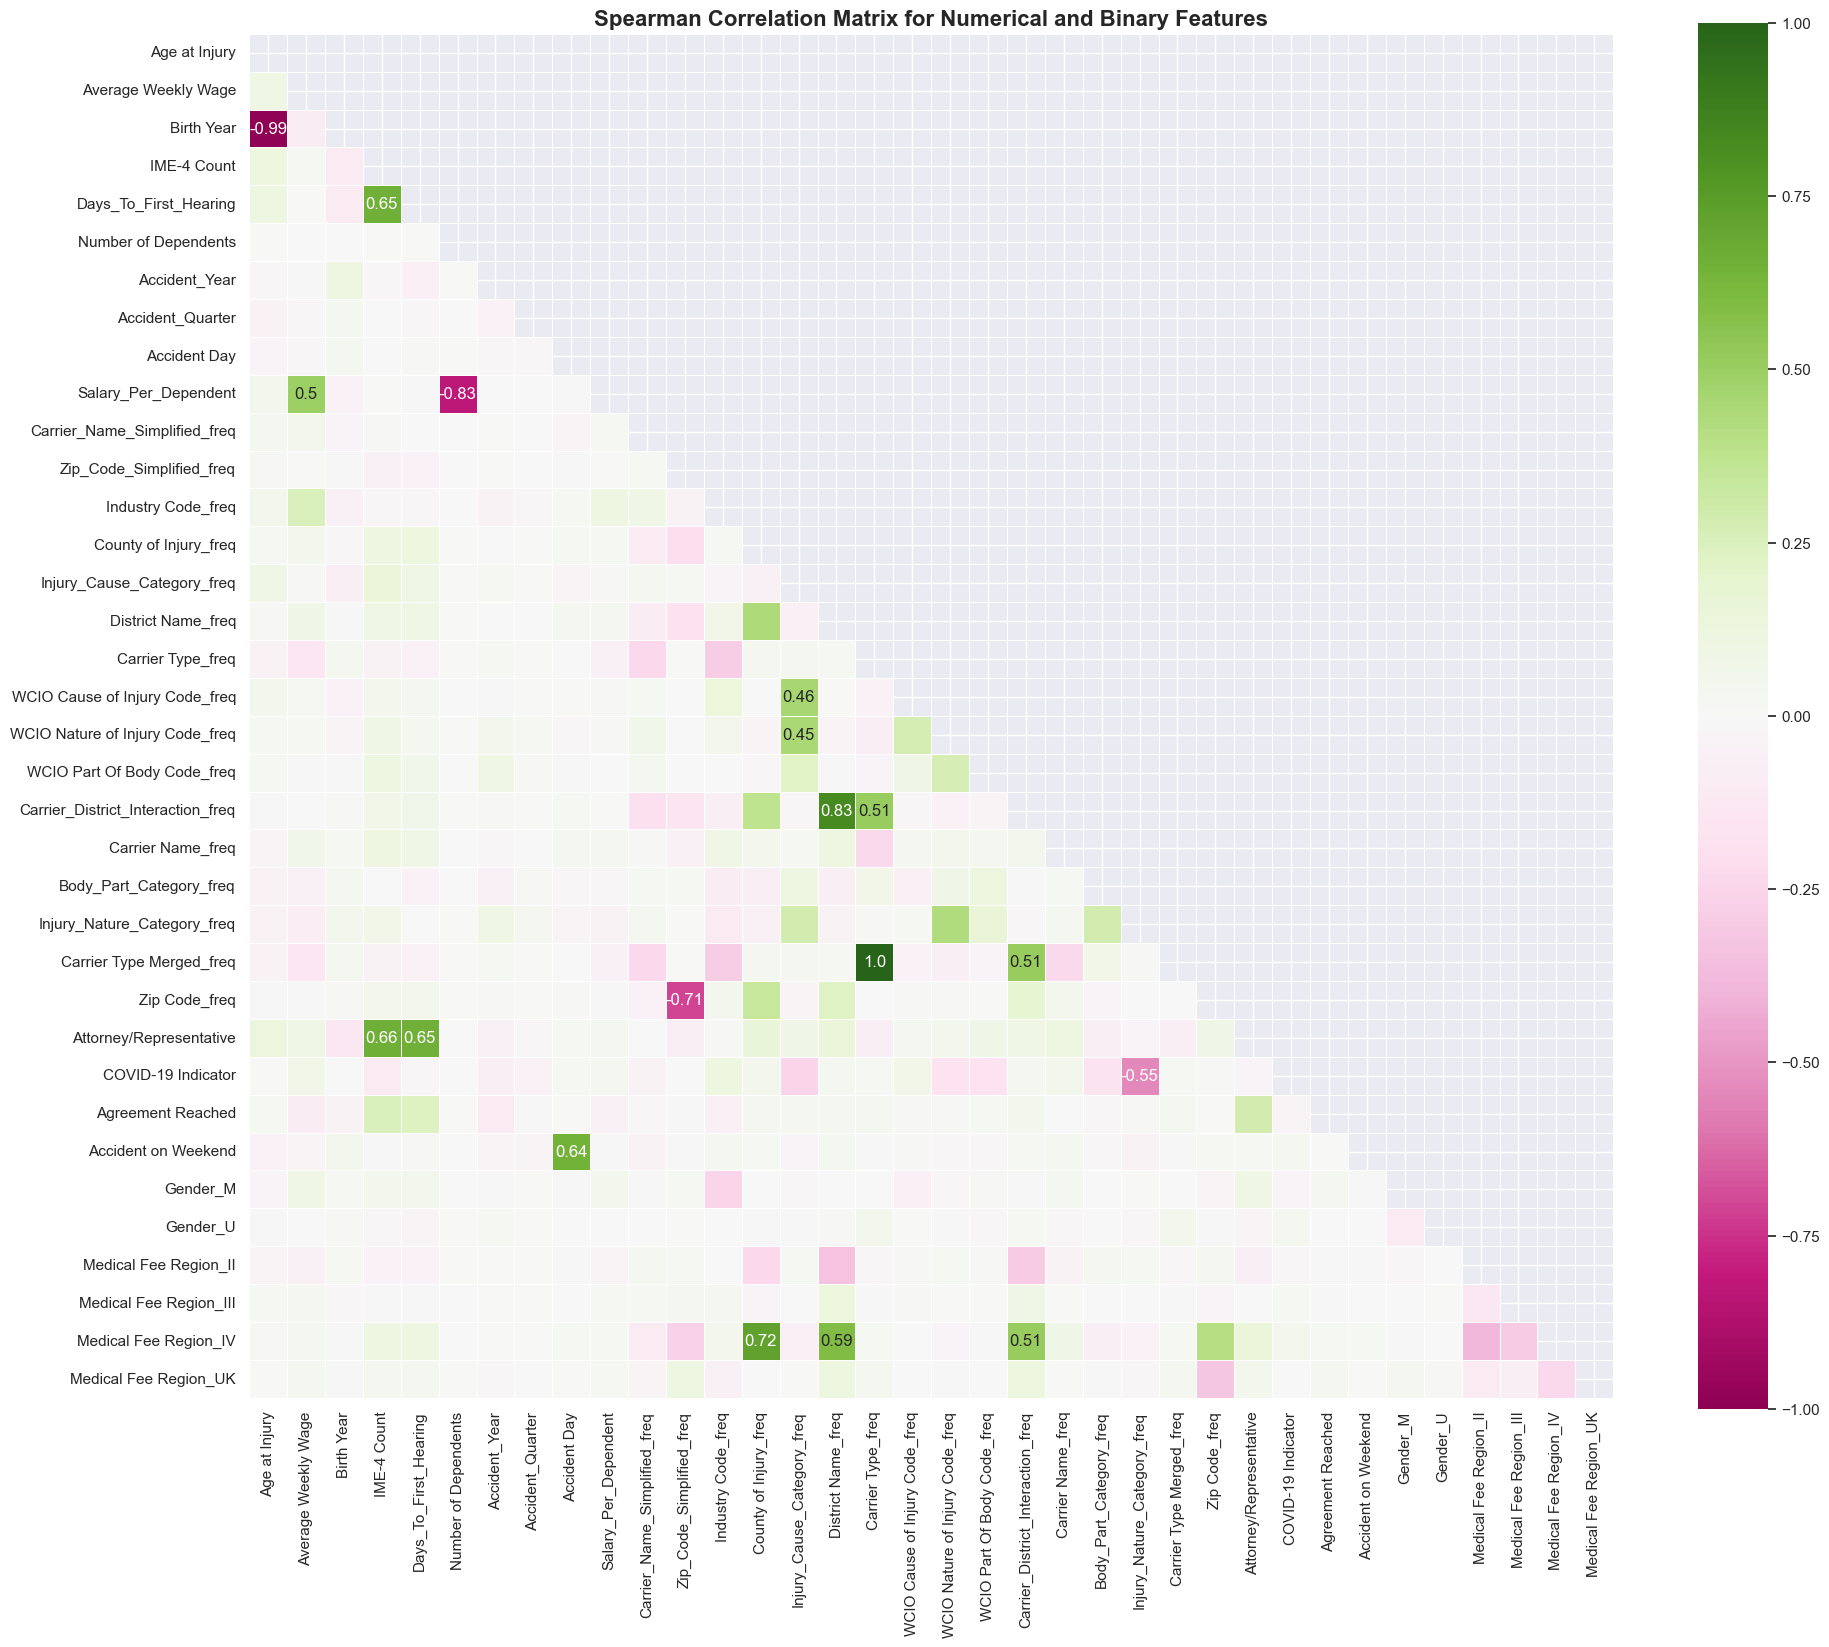

In [54]:
# Select numerical and binary features for correlation analysis
corr_features = feature_categories["numerical"] + feature_categories["binary"]

# Compute correlation matrix
correlation_matrix = X_train_final[corr_features].corr(method='spearman')

# Plot correlation matrix using the defined function
plot_matrix(
    data=correlation_matrix,
    title="Spearman Correlation Matrix for Numerical and Binary Features",
    threshold=0.45,
    figsize=(22, 18)
)


Based on the Spearman correlation matrix analysis, several features exhibit high correlations with one another. To reduce **multicollinearity** and improve **model efficiency**, decisions were made to retain the most interpretable or representative features. The table below outlines the detailed reasoning, correlations, and actions taken:

| **Feature Pairs**                                    | **Correlation** | **Decision**                                                                 | **Retained Feature**            | **Dropped Feature(s)**                 |
|------------------------------------------------------|-----------------|-----------------------------------------------------------------------------|---------------------------------|---------------------------------------|
| **Birth Year** and **Age at Injury**                 | -0.99           | Retain `Age at Injury` because it is more interpretable.                    | `Age at Injury`                 | `Birth Year`                          |
| **Salary_Per_Dependent** and **Average Weekly Wage** | 0.50            | Retain `Salary_Per_Dependent` as it explains wage-related information.      | `Salary_Per_Dependent`          | `Average Weekly Wage`                 |
| **Salary_Per_Dependent** and **Number of Dependents**| -0.83           | Retain `Salary_Per_Dependent` as it incorporates dependents' impact.        | `Salary_Per_Dependent`          | `Number of Dependents`                |
| **IME-4 Count** and **Days_To_First_Hearing**        | 0.65            | Retain `IME-4 Count` as it represents both features' information.           | `IME-4 Count`                   | `Days_To_First_Hearing`               |
| **IME-4 Count** and **Attorney/Representative**      | 0.66            | Retain `IME-4 Count` as it is more informative.                             | `IME-4 Count`                   | `Attorney/Representative`             |
| **Zip_Code_freq** and **Zip_Code_Simplified_freq**   | -0.71           | Retain `Zip_Code_Simplified_freq` as it is a simplified version.            | `Zip_Code_Simplified_freq`      | `Zip_Code_freq`                       |
| **Carrier Type Merged_freq** and **Carrier Type_freq**| 1.00            | Retain `Carrier Type Merged_freq` for its aggregated representation.        | `Carrier Type Merged_freq`      | `Carrier Type_freq`                   |
| **Carrier_District_Interaction_freq** and **District Name_freq**| 0.83  | Delete `Carrier_District_Interaction_freq` as it overlaps with others.      | `District Name_freq`            | `Carrier_District_Interaction_freq`   |
| **Carrier_District_Interaction_freq** and **Carrier Type Merged_freq**| 0.51 | Retain `Carrier Type Merged_freq` for its information.                      | `Carrier Type Merged_freq`      | -                                     |
| **Accident on Weekend** and **Accident Day**         | 0.64            | Retain `Accident Day` as it provides richer information.                    | `Accident Day`                  | `Accident on Weekend`                 |
| **COVID-19 Indicator** and **Injury_Nature_Category_freq** | -0.55     | Retain `Injury_Nature_Category_freq` as it contains more contextual value.  | `Injury_Nature_Category_freq`   | `COVID-19 Indicator`                  |
| **Medical Fee Region_IV** and **County of Injury_freq** | 0.72           | Retain `County of Injury_freq` and `District Name_freq` for richer context. | `County of Injury_freq`, `District Name_freq` | `Medical Fee Region_IV`        |
| **Injury_Cause_Category_freq** and **WCIO Cause of Injury Code_freq** | 0.46 | Retain `WCIO Cause of Injury Code_freq` and `WCIO Nature of Injury Code_freq` as they are more informative. | `WCIO Cause of Injury Code_freq`, `WCIO Nature of Injury Code_freq` | `Injury_Cause_Category_freq` |

While **`Carrier Type`** has a moderate correlation with `Carrier_District_Interaction_freq`, it was decided to **retain `Carrier Type`** for further analysis due to its standalone interpretability and potential importance in modeling.

In [55]:
# Features to drop based on high correlation
features_to_drop = [
    'Birth Year',                  # Retain Age at Injury
    'Average Weekly Wage',         # Retain Salary_Per_Dependent
    'Number of Dependents',        # Retain Salary_Per_Dependent
    'Days_To_First_Hearing',       # Retain IME-4 Count
    'Attorney/Representative',     # Retain IME-4 Count
    'Zip Code_freq',               # Retain Zip_Code_Simplified_freq
    'Carrier Type_freq',           # Retain Carrier Type Merged_freq
    'Carrier_District_Interaction_freq', # Retain District Name_freq
    'Accident on Weekend',         # Retain Accident Day
    'COVID-19 Indicator',           # Retain Injury_Nature_Category_freq
    'Medical Fee Region_IV',       
    'Injury_Cause_Category_freq'
]

# Drop features from the datasets
X_train_final.drop(columns=features_to_drop, inplace=True)
X_val_final.drop(columns=features_to_drop, inplace=True)
X_test_final.drop(columns=features_to_drop, inplace=True)

# Update the feature_categories dictionary
feature_categories["numerical"] = [feat for feat in feature_categories["numerical"] if feat not in features_to_drop]
feature_categories["binary"] = [feat for feat in feature_categories["binary"] if feat not in features_to_drop]
feature_categories["categorical"] = [feat for feat in feature_categories["categorical"] if feat not in features_to_drop]

To ensure all highly correlated features have been addressed, the correlation matrix will be re-examined. This step helps verify that no significant correlations remain, ensuring a cleaner and more efficient feature set for modeling.

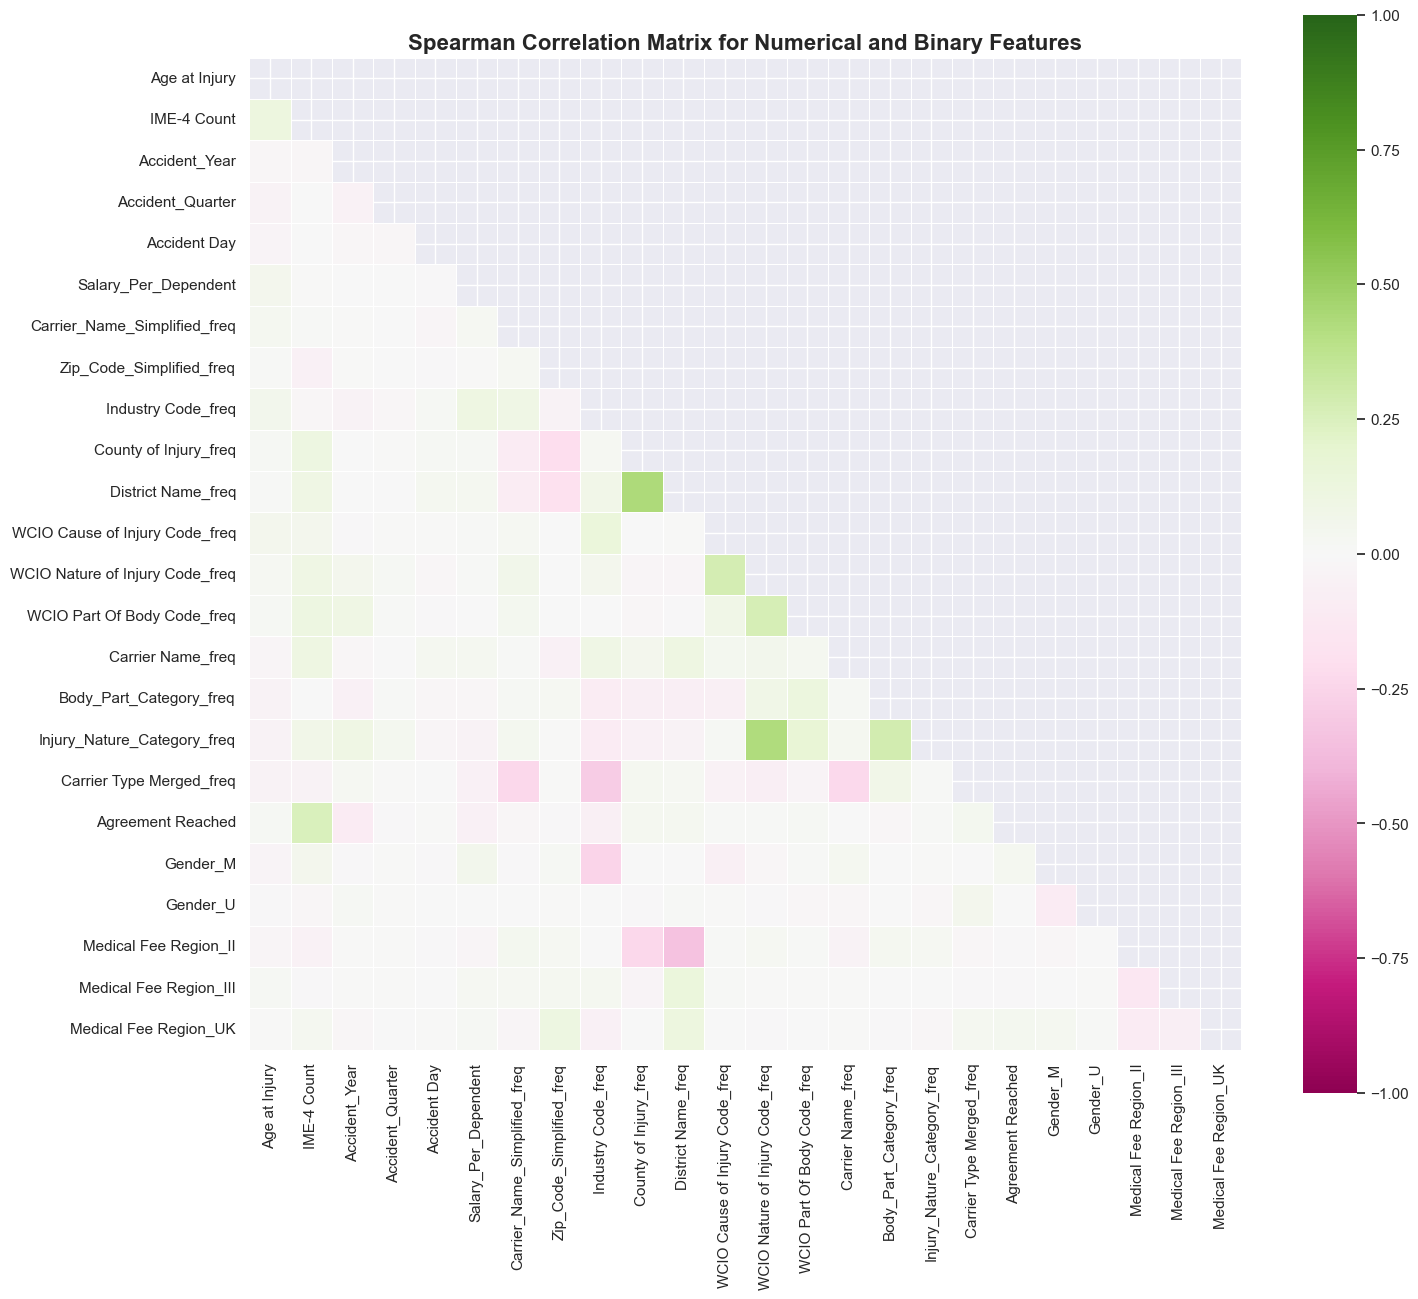

In [56]:
# Select numerical and binary features for correlation analysis
corr_features = feature_categories["numerical"] + feature_categories["binary"]

# Compute correlation matrix
correlation_matrix = X_train_final[corr_features].corr(method='spearman')

# Plot correlation matrix using the defined function
plot_matrix(
    data=correlation_matrix,
    title="Spearman Correlation Matrix for Numerical and Binary Features",
    threshold=0.45,
    figsize=(16, 14)
)

With all highly correlated features successfully removed, the dataset is now streamlined and ready for the next steps in the pipeline. In this final step, the processed and encoded datasets will be saved to ensure they are prepared for modeling in subsequent notebooks.

## 4.4. Feature Grouping and Export <a class="anchor" id="sub_section_4_4"></a>

[Back to 4. Encoding and Feature Categorization](#chapter4)<br>

In this section, features are grouped into categorical, binary, and numerical categories based on their properties. The resulting dictionary provides a structured and reusable way to organize features for feature selection and modeling in subsequent notebooks.

Storing this dictionary ensures consistency across all modeling stages while avoiding repeated code. It will be imported and used in Notebooks 4, 5, and 6, where it facilitates efficient application of feature selection techniques.

In [57]:
import pickle

# Group features into categories
feature_categories = {
    "categorical": [
        'Income_Category', 'Age Group', 'promptness_category',
        'promptness_C2_category', 'promptness_C3_category', 'Industry Risk'
    ],
    "binary": [
        'Gender_M', 'Gender_U', 
        'Medical Fee Region_II', 'Medical Fee Region_III', 'Medical Fee Region_UK'
    ],
    "numerical": [
        'Age at Injury', 'IME-4 Count', 'Accident_Quarter', 
        'Accident_Year', 'Accident Day', 'Salary_Per_Dependent', 
        'Carrier_Name_Simplified_freq', 'Zip_Code_Simplified_freq',
        'Industry Code_freq', 'County of Injury_freq', 'District Name_freq', 
        'WCIO Cause of Injury Code_freq', 'WCIO Nature of Injury Code_freq', 
        'WCIO Part Of Body Code_freq', 'Carrier Name_freq', 
        'Body_Part_Category_freq', 'Injury_Nature_Category_freq', 
        'Carrier Type Merged_freq'
    ]
}

#Save the dictionary to a pickle file
output_file = "feature_categories.pkl"
with open(output_file, "wb") as file:
    pickle.dump(feature_categories, file)
print(f"Feature categories dictionary saved to: {output_file}")

Feature categories dictionary saved to: feature_categories.pkl


# 5. Save Dataset for Modelling <a class="anchor" id="chapter5"></a>
[Back to ToC](#toc)<br>


In [58]:
# Define output directory for the next notebook
output_folder = "../processed_datasets"
os.makedirs(output_folder, exist_ok=True)

# Paths for saving datasets
X_train_path = os.path.join(output_folder, "X_train_model.csv")
X_val_path = os.path.join(output_folder, "X_val_model.csv")
df_test_path = os.path.join(output_folder, "df_test_model.csv")

# Save X datasets to CSV
X_train_final.to_csv(X_train_path, index=True)
X_val_final.to_csv(X_val_path, index=True)
X_test_final.to_csv(df_test_path, index=True)

# Confirmation messages
print("Datasets saved successfully for Feature Selection & Modelling:")
print(f"Training features saved to: {X_train_path}")
print(f"Validation features saved to: {X_val_path}")
print(f"Test data saved to: {df_test_path}")

Datasets saved successfully for Feature Selection & Modelling:
Training features saved to: ../processed_datasets/X_train_model.csv
Validation features saved to: ../processed_datasets/X_val_model.csv
Test data saved to: ../processed_datasets/df_test_model.csv
